Merge draft datasets

In [1]:
import pandas as pd

draftnet_f = '../data/nbadraft_strengths_weaknesses_20240625.csv'
alltimedraft_f = '../data/alltime_draft_20240625.csv'

draftnet_df = pd.read_csv(draftnet_f)
alltimedraft_df = pd.read_csv(alltimedraft_f)

# for getting a column to join on
alltimedraft_df['player'] = alltimedraft_df.PLAYER_NAME.str.lower().str.replace(' ','-')

In [2]:
keep_cols = ['PERSON_ID','PLAYER_NAME','SEASON','strengths','weaknesses', 'overall','Athleticism','Size','Defense','Strength','Quickness',
    'Leadership','JumpShot','NBAReady','Rebounding', 'Potential','PostSkills','Intangibles','BallHandling','Passing']
rename_dict = {'PERSON_ID':'person_id','PLAYER_NAME':'player','SEASON':'season'}
df = pd.merge(alltimedraft_df, draftnet_df, on='player', how='inner')[keep_cols]
df.rename(rename_dict, axis=1, inplace=True)
df = df.loc[df.season >= 2006]
df = df.dropna(subset=['strengths'])
df.head()

,person_id,player,season,strengths,weaknesses,overall,Athleticism,Size,Defense,Strength,Quickness,Leadership,JumpShot,NBAReady,Rebounding,Potential,PostSkills,Intangibles,BallHandling,Passing
0,1641705,Victor Wembanyama,2023,A generational talent … The sky is the limit a...,"He has bulked up considerably, but he still ne...",101,9,10,9,6,8,8,8,8,8.0,10,8.0,9,NaN,NaN
1,1641706,Brandon Miller,2023,An extremely talented 6’9 SF/PF with a lanky f...,"Though he has solid athleticism, he lacks grea...",95,9,9,8,8,8,7,7,8,NaN,9,NaN,7,7.0,8.0
2,1630703,Scoot Henderson,2023,Henderson is a 6’2 190 guard with outstanding ...,3-point shot needs improvement (27 3FG%); adde...,97,9,8,7,8,9,8,7,8,NaN,9,NaN,8,8.0,8.0
3,1641708,Amen Thompson,2023,Thompson is a 6’7 210 perimeter player who is ...,Jump shot is a big concern currently (25 3FG%)...,93,9,8,8,8,9,7,6,7,NaN,8,NaN,8,8.0,7.0
4,1641709,Ausar Thompson,2023,Thompson is a 6’7 215 wing with the physical t...,Can be too reliant on his athleticism; doesn’t...,93,9,8,8,8,8,8,7,7,NaN,8,NaN,8,7.0,7.0


Add in the all star information

In [3]:
allstar_f = '../data/nba_allstar_all_20240625.csv'
allstar_df = pd.read_csv(allstar_f)
allstar_df = allstar_df.loc[allstar_df.year >= 2001]

In [4]:
import numpy as np
all_star_indicator = []
all_star_first_year = []
for index, row in df.iterrows():
    if row['player'] in allstar_df['Player'].values:
        all_star_indicator.append(1)
        player_allstar = allstar_df.loc[allstar_df['Player'] == row['player']]
        year_min = player_allstar.year.min()
        allstar_player_year = year_min - row['season']
        all_star_first_year.append(allstar_player_year)
    else:
        all_star_indicator.append(0)
        all_star_first_year.append(np.nan)
df['allstar_bool'] = all_star_indicator
df['allstar_first_year'] = all_star_first_year
df['within7'] = (df.allstar_first_year <= 7).astype(int)
df['within5'] = (df.allstar_first_year <= 5).astype(int)
df.drop_duplicates(subset='player', inplace=True)

nlp feature extraction

within 5 years

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing Punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Joining tokens back into a single text
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Get names of 2023 mock draftees

In [7]:
import requests
from bs4 import BeautifulSoup
draft_2023_url = 'https://www.nbadraft.net/nba-mock-drafts/'
response = requests.get(draft_2023_url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', id='nba_mock_consensus_table')
df2023 = pd.read_html(str(table))[0]
player_2023_list = []
for player_name in df2023.Player:
    player_2023_list.append(player_name.lower().replace(' ','-'))

Create dataframe containing the merged df and the 2023 mock draftees called all_df

In [8]:
# combine input data and 2023 data temporarily to run all through vectorizer
all_df = pd.concat([df, draftnet_df.loc[draftnet_df.player.isin(player_2023_list)]])
all_df['text'] = all_df['strengths'] + ' ' + all_df['weaknesses']
all_df['text'] = all_df['text'].apply(preprocess_text)
all_df = all_df.reset_index(drop=True)

# apply NLP vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the max_features parameter
input_cols = ['overall','Athleticism','Size','Defense','Strength','Quickness', 'Leadership','JumpShot','NBAReady']
X = vectorizer.fit_transform(all_df['text'])

# combine vectorized array and the other input columns
X = pd.concat([pd.DataFrame(X.toarray()), all_df[input_cols]], axis=1)
X.columns = X.columns.astype(str) # convert to all string names
# inds = np.where(all_df['draft_year'] == '2023')[0]
# X_2023 = X[inds]
# X = X[all_df['draft_year'] != '2023']

In [18]:
from datetime import datetime
n = 7
year_thresh = datetime.now().year - n
if n == 5:
    mask = (all_df.within5 == 1) | (all_df.season <= year_thresh)
    # data = df.loc[(df.within5 == 1) | (df.season <= 2018)]
else:
    mask = (all_df.within7 == 1) | (all_df.season <= year_thresh)
    # data = df.loc[(df.within7 == 1) | (df.season <= 2016)]

mask = mask # & (all_df.draft_year != 2024)
# data['text'] = data['strengths'] + ' ' + data['weaknesses']
# data['text'] = data['text'].apply(preprocess_text)

# vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the max_features parameter
# X = vectorizer.fit_transform(data['text'])
X_rest = X[mask]
y = all_df[mask]['within7']

In [19]:
# Step 4: Model Training
X_train, X_test, y_train, y_test = train_test_split(X_rest, y, test_size=0.2, random_state=42, stratify=y)
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\Andy\anaconda3\envs\nba-stats\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [20]:
from sklearn.metrics import accuracy_score

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy:', accuracy)

Model Accuracy: 0.8811881188118812


In [21]:
def confusion_matrix_scorer(clf, X, y):
    from sklearn.metrics import confusion_matrix
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

In [19]:
# from sklearn.model_selection import KFold, cross_validate
# kf = KFold(n_splits=6, shuffle=True, random_state=2)
# scoring = ['accuracy','precision','recall','f1','roc_auc','neg_log_loss']
# model = LogisticRegression()
# scores = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring)

# for metric in scoring:
#     metric_scores = scores[f'test_{metric}']
#     print(f'{metric}: {metric_scores}')

In [22]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

param_grid = {
    'C': [5, 10, 15, 20],
    'penalty': ['l1','l2'],
    'solver': ['liblinear'],
    'class_weight': [None, class_weights],
    'max_iter': [1000]
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy')

grid_search.fit(X_train, y_train)

print('Best hyperparameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

c:\Users\Andy\anaconda3\envs\nba-stats\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Andy\anaconda3\envs\nba-stats\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Andy\anaconda3\envs\nba-stats\lib\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "c:\Users\Andy\anaconda3\envs\nba-stats\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter

Best hyperparameters:  {'C': 5, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.8836728395061728


Now try it out on this year's draft class

Get test stats

In [23]:
model = LogisticRegression(**grid_search.best_params_)
model.fit(X_train, y_train)

LogisticRegression(C=5, max_iter=1000, penalty='l1', solver='liblinear')

In [24]:
def confusion_matrix_scorer(clf, X, y):
    from sklearn.metrics import confusion_matrix
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

from sklearn.model_selection import KFold, cross_validate
kf = KFold(n_splits=6, shuffle=True, random_state=2)
scoring = ['accuracy','precision','recall','f1','roc_auc','neg_log_loss']
model = LogisticRegression(**grid_search.best_params_)
scores = cross_validate(model, X_rest, y, cv=kf, scoring=scoring)

for metric in scoring:
    metric_scores = scores[f'test_{metric}']
    print(f'{metric}: {metric_scores}')

accuracy: [0.85882353 0.86904762 0.82142857 0.8452381  0.92857143 0.89285714]
precision: [0.         0.33333333 0.5        0.         0.75       0.        ]
recall: [0.         0.1        0.06666667 0.         0.375      0.        ]
f1: [0.         0.15384615 0.11764706 0.         0.5        0.        ]
roc_auc: [0.65866667 0.73378378 0.81932367 0.68617684 0.79276316 0.51480263]
neg_log_loss: [-0.38822908 -0.31785946 -0.40565879 -0.3980468  -0.27127774 -0.41348667]


In [29]:
# data = draftnet_df.loc[draftnet_df.draft_year == '2023']
# data['text'] = data['strengths'] + ' ' + data['weaknesses']
# data['text'] = data['text'].apply(preprocess_text)

# mask = all_df['draft_year'] == '2023'
# inds = np.where(all_df['draft_year'] == '2023')[0]
# X_2023 = X[mask]

# vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the max_features parameter
# tmp_X = vectorizer.fit_transform(data['text'])
# tmp_X = 

model = LogisticRegression(**grid_search.best_params_)
model.fit(X_rest, y)
# y_pred = model.predict(data['text'])

LogisticRegression(C=5, max_iter=1000, penalty='l1', solver='liblinear')

In [30]:
mask = all_df['draft_year'] == 2024
# mask = all_df['draft_year'] == '2023'
# mask = all_df.player.isin(player_2023_list)
X_2023 = X[mask]
y_pred_prob = model.predict_proba(X_2023)

In [31]:
df_2023 = all_df[mask]
df_2023['allstar_prob'] = [x[1] * 100 for x in y_pred_prob]
df_2023 = df_2023[['player','allstar_prob']]
df_2023.head()

C:\Users\Andy\AppData\Local\Temp\ipykernel_2752\443112442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['allstar_prob'] = [x[1] * 100 for x in y_pred_prob]


,player,allstar_prob
765,alexandre-sarr,23.894234
766,baylor-scheierman,5.057672
767,cam-christie,17.179742
768,carlton-carrington,11.064229
769,cody-williams,30.463787


In [ ]:
D:\Andy\python\nba-analysis\data\player_season_stats

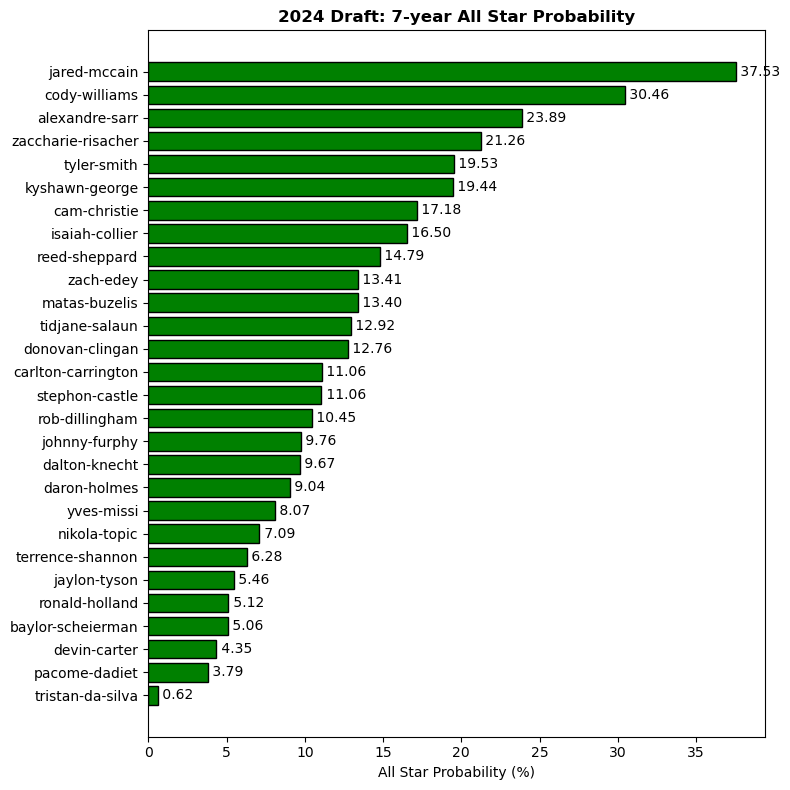

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Sort the dataframe by allstar_prob in descending order
df = df_2023.sort_values('allstar_prob', ascending=False)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(df['player'], df['allstar_prob'], color='green', edgecolor='k')

# Set labels and title
ax.set_xlabel('All Star Probability (%)')
# ax.set_ylabel('Player')
ax.set_title('2024 Draft: 7-year All Star Probability', weight='bold')

# Invert the y-axis to show the highest probability at the top
ax.invert_yaxis()

# Add data values to the bars
for i, prob in enumerate(df['allstar_prob']):
    ax.text(prob + 0.01, i, f' {prob:.2f}', ha='left', va='center')

# Adjust layout and spacing
plt.tight_layout()

# Save the chart as an image
plt.savefig('../outputs/2024_allstar_prob.png', dpi=300, bbox_inches='tight')

# Display the chart
plt.show()